### BNB with Tensor Parallelism

In [1]:
import torch
import copy
from bitsandbytes.nn.modules import Params4bit, Linear4bit
from bitsandbytes.functional import dequantize_4bit
import bitsandbytes as bnb
from bitsandbytes.functional import dequantize_4bit, QuantState

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

In [3]:
blocksize = 64
quant_type = "nf4"
quant_storage = torch.uint8

data = torch.randn(128,256).to(torch.bfloat16)
param = Params4bit(data, blocksize=blocksize, quant_type=quant_type, 
                   quant_storage=quant_storage, compress_statistics=False)

In [4]:
if quant_storage == torch.uint8:
    pack_factor = 2

In [5]:
param

Parameter containing:
Parameter(Params4bit([[-0.1260, -1.6250,  0.0508,  ...,  0.3379, -1.7500,  1.1484],
            [-0.2305, -1.3047, -2.0312,  ..., -0.1328, -0.3125,  1.8594],
            [-1.1875,  0.9766,  0.0840,  ..., -2.2812,  0.6016,  1.1328],
            ...,
            [ 1.1875,  1.0234,  1.3281,  ...,  1.5781, -0.7227,  0.5156],
            [ 0.0610, -0.3477,  1.2578,  ..., -1.7109,  1.0781,  0.6914],
            [ 0.2002, -0.7422,  0.0527,  ...,  1.1953, -0.0952,  0.0854]],
           dtype=torch.bfloat16))

In [6]:
param.cuda();

In [7]:
param.shape, param.quant_type, param.quant_storage, param.blocksize

(torch.Size([16384, 1]), 'nf4', torch.uint8, 64)

In [8]:
param.shape

torch.Size([16384, 1])

In [9]:
param.numel() / data.numel()

0.5

In [10]:
param.quant_state.as_dict()

{'quant_type': 'nf4',
 'absmax': tensor([2.6406, 2.4062, 3.7812, 2.2344, 2.7500, 3.2500, 2.2500, 2.8594, 2.7656,
         2.4688, 3.2969, 3.4844, 2.7812, 2.2188, 2.9375, 3.2812, 2.1094, 2.8125,
         2.2344, 3.2344, 3.2188, 2.8125, 2.3906, 2.2812, 2.7031, 3.5938, 2.5156,
         2.9219, 2.1875, 3.0469, 2.5781, 2.5781, 2.2188, 2.8125, 2.3281, 2.6094,
         2.9219, 2.7344, 2.1719, 3.4375, 2.5000, 3.0625, 2.4688, 2.5625, 2.9531,
         2.8125, 2.7969, 2.2500, 3.6094, 2.4062, 2.0781, 2.4531, 3.3281, 2.6250,
         3.1250, 2.7969, 2.8594, 2.4844, 2.8906, 2.5000, 2.1719, 3.1406, 2.6094,
         2.4375, 3.0000, 2.2188, 3.4062, 3.9688, 2.6250, 2.5938, 2.2500, 3.0000,
         2.7188, 2.5625, 2.5156, 3.3750, 2.5469, 2.8125, 3.0781, 2.4688, 2.5781,
         3.3281, 2.5781, 1.7109, 2.9375, 2.0781, 2.2031, 2.3750, 2.0312, 2.3750,
         2.4688, 2.6406, 2.2812, 2.2344, 3.2031, 2.5312, 1.8203, 2.3438, 2.0625,
         2.7500, 2.5312, 2.6094, 2.4844, 2.7188, 2.6562, 2.1094, 1.8594, 2.46

In [11]:
input_size_per_partition = 64
output_size_per_partition = 64

In [12]:
# row-major quantization, reshape for vllm tensor parallelism
qweight = param.data.reshape(data.size(0), data.size(1) // pack_factor); qweight.shape

torch.Size([128, 128])

In [13]:
qweight

tensor([[ 97, 119,  55,  ...,  65, 201,  29],
        [ 98,  24,  97,  ..., 156, 134, 110],
        [ 59, 112,  71,  ...,  58,  81, 155],
        ...,
        [203, 201, 227,  ...,  20, 173,  73],
        [117, 217, 181,  ...,  65,  97, 202],
        [132, 122, 134,  ...,  38,  44, 119]], device='cuda:0',
       dtype=torch.uint8)

In [14]:
qweight.view(-1,1)

tensor([[ 97],
        [119],
        [ 55],
        ...,
        [ 38],
        [ 44],
        [119]], device='cuda:0', dtype=torch.uint8)

In [15]:
deqweight = dequantize_4bit(qweight.view(-1,1), param.quant_state, blocksize=blocksize)

In [16]:
(data - torch.randn_like(data)).norm()

tensor(254., dtype=torch.bfloat16)

In [17]:
(data - deqweight.cpu()).norm()

tensor(16.5000, dtype=torch.bfloat16)

In [18]:
x = torch.randn(4, 128).cuda().to(torch.bfloat16)

In [19]:
param.quant_state.as_dict()

{'quant_type': 'nf4',
 'absmax': tensor([2.6406, 2.4062, 3.7812, 2.2344, 2.7500, 3.2500, 2.2500, 2.8594, 2.7656,
         2.4688, 3.2969, 3.4844, 2.7812, 2.2188, 2.9375, 3.2812, 2.1094, 2.8125,
         2.2344, 3.2344, 3.2188, 2.8125, 2.3906, 2.2812, 2.7031, 3.5938, 2.5156,
         2.9219, 2.1875, 3.0469, 2.5781, 2.5781, 2.2188, 2.8125, 2.3281, 2.6094,
         2.9219, 2.7344, 2.1719, 3.4375, 2.5000, 3.0625, 2.4688, 2.5625, 2.9531,
         2.8125, 2.7969, 2.2500, 3.6094, 2.4062, 2.0781, 2.4531, 3.3281, 2.6250,
         3.1250, 2.7969, 2.8594, 2.4844, 2.8906, 2.5000, 2.1719, 3.1406, 2.6094,
         2.4375, 3.0000, 2.2188, 3.4062, 3.9688, 2.6250, 2.5938, 2.2500, 3.0000,
         2.7188, 2.5625, 2.5156, 3.3750, 2.5469, 2.8125, 3.0781, 2.4688, 2.5781,
         3.3281, 2.5781, 1.7109, 2.9375, 2.0781, 2.2031, 2.3750, 2.0312, 2.3750,
         2.4688, 2.6406, 2.2812, 2.2344, 3.2031, 2.5312, 1.8203, 2.3438, 2.0625,
         2.7500, 2.5312, 2.6094, 2.4844, 2.7188, 2.6562, 2.1094, 1.8594, 2.46

In [29]:
input_size, output_size = data.size()

In [34]:
input_size, output_size

(128, 256)

### Column Parallel

The linear layer is defined as Y = XA + b. A is parallelized along its second dimension as A = [A_1, ..., A_p].

In [37]:
num_partitions = 2

In [20]:
qweight.shape

torch.Size([128, 128])

In [21]:
output_size_per_partition

64

In [22]:
qweight_partitioned = qweight.split(output_size_per_partition, dim=1)

In [23]:
len(qweight_partitioned)

2

In [24]:
for w in qweight_partitioned: print(w.shape)

torch.Size([128, 64])
torch.Size([128, 64])


In [25]:
orig_absmax = param.quant_state.absmax

In [26]:
orig_absmax.shape

torch.Size([512])

In [31]:
orig_absmax_reshaped = orig_absmax.reshape(input_size, data.size(1) // blocksize)

In [33]:
orig_absmax_reshaped.dtype, orig_absmax_reshaped.shape

(torch.float32, torch.Size([128, 4]))

In [91]:
num_partitions = len(qweight_partitioned)

In [38]:
absmax_partitioned = orig_absmax_reshaped.split(orig_absmax_reshaped.size(1) // num_partitions, dim=1)

In [39]:
for a in absmax_partitioned: print(a.shape)

torch.Size([128, 2])
torch.Size([128, 2])


In [40]:
len(qweight_partitioned), len(absmax_partitioned)

(2, 2)

In [41]:
quant_state = copy.deepcopy(param.quant_state)

In [42]:
quant_state.shape = torch.Size([quant_state.shape[0], quant_state.shape[1]//num_partitions])

In [43]:
quant_state.shape

torch.Size([128, 128])

In [44]:
quant_state.absmax = absmax_partitioned[0].contiguous().view(-1)
deqweight_part1 = dequantize_4bit(qweight_partitioned[0].contiguous().view(-1,1), quant_state=quant_state)

quant_state.absmax = absmax_partitioned[1].contiguous().view(-1)
deqweight_part2 = dequantize_4bit(qweight_partitioned[1].contiguous().view(-1,1), quant_state=quant_state)

In [45]:
deqweight_part1.shape, deqweight_part2.shape

(torch.Size([128, 128]), torch.Size([128, 128]))

In [46]:
# quant_state.as_dict()

In [47]:
deqweight.shape

torch.Size([128, 256])

In [48]:
torch.cat([deqweight_part1, deqweight_part2], dim=1).shape

torch.Size([128, 256])

In [49]:
assert torch.equal(deqweight, torch.cat([deqweight_part1, deqweight_part2], dim=1))

In [50]:
out1 = (x @ deqweight_part2)

In [51]:
out2 = bnb.matmul_4bit(x, qweight_partitioned[1].contiguous().view(-1,1), quant_state=quant_state)

In [52]:
assert torch.equal(out1, out2)

In [53]:
out2.shape

torch.Size([4, 128])

### Row Parallel

The linear layer is defined as Y = XA + b. A is parallelized along
its first dimension and X along its second dimension as:

```
    -   -
    | A_1 |
    | .   |
A = | .   |        X = [X_1, ..., X_p]
    | .   |
    | A_p |
    -   -
```

In [54]:
qweight_partitioned = qweight.split(output_size_per_partition, dim=0)

In [55]:
num_partitions = len(qweight_partitioned); num_partitions

2

In [56]:
for w in qweight_partitioned: print(w.shape)

torch.Size([64, 128])
torch.Size([64, 128])


In [57]:
orig_absmax = param.quant_state.absmax

In [58]:
orig_absmax_reshaped = orig_absmax.reshape(input_size, data.size(1) // blocksize)

In [59]:
absmax_partitioned = orig_absmax.split(len(orig_absmax) // num_partitions, dim=0)

In [60]:
len(absmax_partitioned)

2

In [61]:
quant_state = copy.deepcopy(param.quant_state)

In [62]:
quant_state.shape = torch.Size([quant_state.shape[0]//num_partitions, quant_state.shape[1]]); quant_state.shape

torch.Size([64, 256])

In [63]:
quant_state.absmax = absmax_partitioned[0].contiguous().view(-1)
deqweight_part1 = dequantize_4bit(qweight_partitioned[0].contiguous().view(-1,1), quant_state=quant_state)

quant_state.absmax = absmax_partitioned[1].contiguous().view(-1)
deqweight_part2 = dequantize_4bit(qweight_partitioned[1].contiguous().view(-1,1), quant_state=quant_state)

In [64]:
assert torch.equal(deqweight, torch.cat([deqweight_part1, deqweight_part2], dim=0))

### Loading

In [3]:
from vllm.model_executor.weight_utils import default_weight_loader, hf_model_weights_iterator

INFO 03-29 13:23:10 pynccl_utils.py:13] vLLM is using nccl==2.18.1


In [2]:
weights_iterator = hf_model_weights_iterator("meta-llama/Llama-2-7b-hf")

In [3]:
for name, loaded_weight in weights_iterator: break

INFO 03-29 08:48:45 weight_utils.py:177] Using model weights format ['*.safetensors']


model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

In [5]:
name, loaded_weight

('model.embed_tokens.weight',
 tensor([[ 1.2517e-06, -1.7881e-06, -4.3511e-06,  ...,  8.9407e-07,
          -6.5565e-06,  8.9407e-07],
         [ 1.8616e-03, -3.3722e-03,  3.9864e-04,  ..., -8.3008e-03,
           2.5787e-03, -3.9368e-03],
         [ 1.0986e-02,  9.8877e-03, -5.0964e-03,  ...,  2.5177e-03,
           7.7057e-04, -5.0049e-03],
         ...,
         [-1.3977e-02, -2.7313e-03, -1.9897e-02,  ..., -1.0437e-02,
           9.5825e-03, -1.8005e-03],
         [-1.0742e-02,  9.3384e-03,  1.2939e-02,  ..., -3.3203e-02,
          -1.6357e-02,  3.3875e-03],
         [-8.3008e-03, -4.0588e-03, -1.1063e-03,  ...,  3.4790e-03,
          -1.2939e-02,  3.1948e-05]], dtype=torch.float16))

In [29]:
weights_iterator = hf_model_weights_iterator("TheBloke/CodeUp-Alpha-13B-HF-AWQ")

In [32]:
for name, loaded_weight in weights_iterator: 
    if 'scales' in name or 'zeros' in name:
        print(name)

model.layers.0.mlp.down_proj.qzeros
model.layers.0.mlp.down_proj.scales
model.layers.0.mlp.gate_proj.qzeros
model.layers.0.mlp.gate_proj.scales
model.layers.0.mlp.up_proj.qzeros
model.layers.0.mlp.up_proj.scales
model.layers.0.self_attn.k_proj.qzeros
model.layers.0.self_attn.k_proj.scales
model.layers.0.self_attn.o_proj.qzeros
model.layers.0.self_attn.o_proj.scales
model.layers.0.self_attn.q_proj.qzeros
model.layers.0.self_attn.q_proj.scales
model.layers.0.self_attn.v_proj.qzeros
model.layers.0.self_attn.v_proj.scales
model.layers.1.mlp.down_proj.qzeros
model.layers.1.mlp.down_proj.scales
model.layers.1.mlp.gate_proj.qzeros
model.layers.1.mlp.gate_proj.scales
model.layers.1.mlp.up_proj.qzeros
model.layers.1.mlp.up_proj.scales
model.layers.1.self_attn.k_proj.qzeros
model.layers.1.self_attn.k_proj.scales
model.layers.1.self_attn.o_proj.qzeros
model.layers.1.self_attn.o_proj.scales
model.layers.1.self_attn.q_proj.qzeros
model.layers.1.self_attn.q_proj.scales
model.layers.1.self_attn.v_pro

### Create Quantized Model Files

In [53]:
from pathlib import Path
import os, json
from safetensors.torch import save_file
import copy
from tqdm import tqdm

In [54]:
model_dir = Path("/home/ubuntu/models/llama-7b-orca-math-100k-full-quantized")
os.makedirs(model_dir, exist_ok=True)

In [55]:
# original quantized layers from fsdp_qlora/train.py
# ["k_proj", "q_proj", "v_proj", "up_proj", "down_proj", "gate_proj"]

In [56]:
# Similar to AWQ for now
quantized_layers = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

In [57]:
orca_math_model_dir = "/home/ubuntu/models/llama-7b-orca-math-100k-full"

In [58]:
weights = safetensors.torch.load_file(glob(os.path.join(orca_math_model_dir, "*.safetensors"))[0])

In [59]:
quantized_state_dict = copy.deepcopy(weights)

In [60]:
pack_factor = 2
blocksize = 64

In [61]:
for n,p in iter(weights.items()):
    if any(l in n for l in quantized_layers) and "weight" in n:
        # output_size x input_size
        print(n, p.shape)
        input_size, output_size = p.shape
        param = Params4bit(p, quant_type="nf4", blocksize=blocksize, compress_statistics=False, quant_storage=torch.uint8)
        param.cuda();

        # reshape for tensor parallelism
        qweight, absmax = param.data.cpu(), param.quant_state.absmax.cpu()        
        qweight = qweight.reshape(input_size, output_size // pack_factor)
        absmax = absmax.reshape(input_size, output_size // blocksize)
                
        quantized_state_dict[n] = qweight
        quantized_state_dict[n.replace(".weight", ".absmax")] = absmax

        param = None
        torch.cuda.empty_cache()

model.layers.0.mlp.down_proj.weight torch.Size([4096, 11008])
model.layers.0.mlp.gate_proj.weight torch.Size([11008, 4096])
model.layers.0.mlp.up_proj.weight torch.Size([11008, 4096])
model.layers.0.self_attn.k_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.v_proj.weight torch.Size([4096, 4096])
model.layers.1.mlp.down_proj.weight torch.Size([4096, 11008])
model.layers.1.mlp.gate_proj.weight torch.Size([11008, 4096])
model.layers.1.mlp.up_proj.weight torch.Size([11008, 4096])
model.layers.1.self_attn.k_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.v_proj.weight torch.Size([4096, 4096])
model.layers.10.mlp.down_proj.weight torch.Size([4096, 11008])
model.layers.10.mlp.gate_proj.weight torch.Size([11008, 4

In [62]:
# save quantized weights
save_file(quantized_state_dict, model_dir/"model_state_dict.safetensors")

In [63]:
# save quant config
quant_config_dict = {
    "weight_bits" : 4,
    "blocksize" : 64,
    "quant_type" : "nf4",
    "quant_storage" : "uint8",
    "compress_statistics" : False
}
quant_config_filename = model_dir/"quantize_config.json"
with open(quant_config_filename, "w+") as f: json.dump(quant_config_dict, f)

In [64]:
# save model config
model_config = AutoConfig.from_pretrained("meta-llama/Llama-2-7b-hf")
model_config_filename = model_dir/"config.json"
with open(model_config_filename, "w+") as f: json.dump(model_config.to_dict(), f)

### BNB Quantized VLLM

In [26]:
# from huggingface_hub import hf_hub_download
# import os
# os.makedirs("/home/ubuntu/models/llama-7b-orca-math-100k-full", exist_ok=True)
# hf_hub_download(repo_id="answerdotai/llama-7b-orca-math-100k-full", 
#                 filename="model_state_dict.safetensors",
#                 local_dir="/home/ubuntu/models/llama-7b-orca-math-100k-full")

In [1]:
import torch
import torch.nn as nn
from typing import List
import safetensors
import safetensors.torch
from pathlib import Path
import bitsandbytes as bnb
from bitsandbytes.functional import dequantize_4bit, QuantState
from bitsandbytes.nn.modules import Params4bit, Linear4bit
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers.generation.configuration_utils import GenerationConfig
from accelerate import init_empty_weights
from glob import glob
import os
from fastcore.parallel import parallel
import copy

In [2]:
# !pip install accelerate

In [3]:
from vllm.sequence import SequenceGroupMetadata, SequenceData

In [4]:
from vllm import LLM, SamplingParams

In [5]:
def replace_linear(model:nn.Module, linear_replacement:nn.Module, quant_config:dict|None=None,
                   skip_modules:List[str]=["lm_head"], **kwargs):
    """
    Replace linear modules with a new Linear module.
    Parameters:
        model (`torch.nn.Module`):
            Input model or `torch.nn.Module` as the function is run recursively.
        linear_replacement (`torch.nn.Module`):
            The linear module that replaces the old one. Only expects standard arguments.
            If other arguments need to be passed, use a lambda.
        skip_modules (`List[str]`, *optional*, defaults to `lm_head`):
            List of modules names not to convert. Defaults to `lm_head`.
    """
    for name, module in model.named_children():
        if name in skip_modules:
            print(f"Skipping {name}")
            continue
        
        if len(list(module.children())) > 0:
            replace_linear(module, linear_replacement, quant_config, skip_modules, **kwargs)

        if isinstance(module, torch.nn.Linear):
            if issubclass(linear_replacement, Linear4bit):
                model._modules[name] = linear_replacement(
                    module.in_features,
                    module.out_features,
                    module.bias is not None,
                    **kwargs
                )
            # elif issubclass(linear_replacement, HQQLinear):
            #     model._modules[name] = linear_replacement(module, quant_config, **kwargs)
            else:
                raise ValueError(f"Unsupported linear replacement: {type(linear_replacement)}")
    return model

In [6]:
def load_and_quantize(module:nn.Module, name:str, value:torch.Tensor, device:torch.device=None, dtype:torch.dtype=None,
                      skip_names:list[str]=[], is_meta_rank:bool=False, low_memory:bool=True, verbose:bool=False,
                      quant_method:str='bnb', is_dora:bool=False):
    """
    Loads `value` tensor into submodule of `module`, optionally skipping `skip_names` and converting to `dtype`.

    Quantizes `Params4bit` on `device` then places on "cpu" if low_memory=True or "meta" if is_meta_rank=True.
    """
    def place_on_device(value):
        if is_meta_rank:
            device = 'meta'
        elif low_memory:
            device = 'cpu'
        return value.to(device=device, dtype=dtype)

    if any([skip_name in name for skip_name in skip_names]):
        if verbose:
            print(f"Skipping {name} because it is in skip_names")
        return

    module_key, _, value_key = name.rpartition('.')
    try:
        submodule = module.get_submodule(module_key)
    except AttributeError as e:
        print(f"Module {module_key} not found:\n{e}")
        return

    try:
        if quant_method=='bnb':
            param = submodule.get_parameter(value_key)
            if isinstance(param, Params4bit):
                # With `sync_module_states=True`, a meta device Params4bit needs to be the same
                # shape as the quantized Params4bit with an initialized quant_state. However,
                # FSDP only syncs parameters and buffers, so the quant_state isn't copied. This
                # workaround quantizes Params4bit to initialize quant_state on all ranks, then
                # replaces Params4bit's data with a meta tensor to free memory on non-rank 0.
                if is_dora:
                    setattr(submodule, "dora_scale", value.norm(p=2, dim=1).to(dtype=dtype).to("cpu"))                
                    print("DORA scale initialized")
                value = type(param)(value.to(device=device, dtype=dtype).data, **param.__dict__).cuda(device)
                if is_meta_rank:
                    value = type(param)(value.data.to("meta"), **value.__dict__)
                elif low_memory:
                    value = type(param)(value.data.to("cpu"), **value.__dict__)
                # print("Loaded quantized layer")
            else:
                value = type(param)(place_on_device(value).data)
                # print("Loaded regular layer")
    except AttributeError:
        # it's a buffer
        value = place_on_device(value)
        pass
    setattr(submodule, value_key, value)

def load_and_quantize_parallel(name_param, model, **kwargs):
    name, param = name_param
    load_and_quantize(model, name, param, **kwargs)

In [7]:
orca_math_model_dir = "/home/ubuntu/models/llama-7b-orca-math-100k-full"

In [8]:
MODEL_NAME = "meta-llama/Llama-2-7b-hf"
cfg = AutoConfig.from_pretrained(MODEL_NAME)
cfg._attn_implementation = "sdpa"
skip_modules = ["lm_head"]
load_param_skip_names = ['inv_freq']
compute_dtype = torch_dtype = torch.bfloat16

In [9]:
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(cfg)
    model.model = replace_linear(model.model, Linear4bit, compute_dtype=compute_dtype,
                                 quant_type='nf4', compress_statistics=False,
                                 quant_storage=torch.uint8, skip_modules=skip_modules)
model.is_loaded_in_4bit = True

In [10]:
weights = safetensors.torch.load_file(glob(os.path.join(orca_math_model_dir, "*.safetensors"))[0])

In [11]:
parallel(load_and_quantize_parallel, 
         iter(weights.items()), 
         n_workers=8, 
         threadpool=True,
         model=model, 
         dtype=torch_dtype, 
         device=torch.cuda.current_device(),
         skip_names=load_param_skip_names,
         is_meta_rank=False,
         verbose=True,
         quant_method="bnb",
         is_dora=False)

(#291) [None,None,None,None,None,None,None,None,None,None...]

In [12]:
model.cuda();

In [13]:
hf_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
hf_tokenizer.pad_token_id = hf_tokenizer.unk_token_id
hf_tokenizer.pad_token = hf_tokenizer.unk_token

In [14]:
input = ""

In [15]:
input = """###Question:
A certain tax rate is some amount per $100.00. The rate, expressed as a percent, is 65%. What is the tax rate in dollars per $100.00?
###Answer:"""

In [16]:
output = model.generate(hf_tokenizer(input, return_tensors="pt")['input_ids'].cuda(),
                        generation_config=GenerationConfig(do_sample=False, max_new_tokens=16, use_cache=True, 
                                                           pad_token_id=hf_tokenizer.pad_token_id)).cpu()
print(hf_tokenizer.decode(output[0]))

<s> ###Question:
A certain tax rate is some amount per $100.00. The rate, expressed as a percent, is 65%. What is the tax rate in dollars per $100.00?
###Answer:
To find the tax rate in dollars per $100.00


In [17]:
#This works fine.
# orca_math_model_dir = "/home/ubuntu/models/llama-7b-orca-math-100k-full"
# llm = LLM(model=orca_math_model_dir, tokenizer="meta-llama/Llama-2-7b-hf", dtype="bfloat16",
#           gpu_memory_utilization=0.8)

# vllm_model = llm.llm_engine.model_executor.driver_worker.model_runner.model

# outputs = llm.generate([input], sampling_params=SamplingParams(max_tokens=16, temperature=0.))
# print(input + outputs[0].outputs[0].text)

In [17]:
orca_math_model_dir = "/home/ubuntu/models/llama-7b-orca-math-100k-full-quantized"
llm = LLM(model=orca_math_model_dir, tokenizer="meta-llama/Llama-2-7b-hf", dtype="bfloat16",
          quantization="bnb", gpu_memory_utilization=0.5)

WARNING 04-04 13:46:18 config.py:744] Casting torch.float16 to torch.bfloat16.
WARNING 04-04 13:46:18 config.py:208] bnb quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 04-04 13:46:18 llm_engine.py:70] Initializing an LLM engine (v0.3.3) with config: model='/home/ubuntu/models/llama-7b-orca-math-100k-full-quantized', tokenizer='meta-llama/Llama-2-7b-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=bnb, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 04-04 13:46:18 pynccl_utils.py:13] vLLM is using nccl==2.18.1
INFO 04-04 13:46:18 selector.py:15] Using FlashAttention backend.
INFO 04-04 13:46:21 model_runner.py:104] Loading model weights took 3.9292 GB
INFO 04-04 13:46:22 gpu_executor.py:94] # GPU blocks: 897, # CPU blocks: 512

In [21]:
outputs = llm.generate([input], sampling_params=SamplingParams(max_tokens=16, temperature=0.))
print(input + outputs[0].outputs[0].text)

Processed prompts: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]

###Question:
A certain tax rate is some amount per $100.00. The rate, expressed as a percent, is 65%. What is the tax rate in dollars per $100.00?
###Answer:
 Cat Abs Abs Abs Cat Cat Cat Cat Cat Cat Cat Cat Cat Cat Cat


In [22]:
vllm_model = llm.llm_engine.model_executor.driver_worker.model_runner.model

In [23]:
quantized_layers = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

In [24]:
# for n,p in model.named_parameters():
#     # if "qkv" in n: break # quantized layers are not casted to dtype, which is correct.
#     # if "lm_head" in n: break
#     if any(l in n for l in quantized_layers):
#         print(n, p.dtype)
#         # assert p.dtype == torch.uint8

#### Compare QKV 

In [25]:
for layer in range(model.config.num_hidden_layers):
    q = model.get_submodule(f'model.layers.{layer}.self_attn.q_proj')
    k = model.get_submodule(f'model.layers.{layer}.self_attn.k_proj')
    v = model.get_submodule(f'model.layers.{layer}.self_attn.v_proj')
    
    # qkv = vllm_model.get_submodule(f'model.layers.{layer}.self_attn.qkv_proj')
    
    # assert torch.equal(q.weight, qkv.weight.split(4096, dim=0)[0].reshape(-1,1))
    # assert torch.equal(k.weight, qkv.weight.split(4096, dim=0)[1].reshape(-1,1))
    # assert torch.equal(v.weight, qkv.weight.split(4096, dim=0)[2].reshape(-1,1))
    
    # assert torch.equal(q.quant_state.absmax, qkv.absmax.view(-1).split(4096*4096//64)[0])
    # assert torch.equal(k.quant_state.absmax, qkv.absmax.view(-1).split(4096*4096//64)[1])
    # assert torch.equal(v.quant_state.absmax, qkv.absmax.view(-1).split(4096*4096//64)[2])
    
    q2 = vllm_model.get_submodule(f'model.layers.{layer}.self_attn.q_proj')
    k2 = vllm_model.get_submodule(f'model.layers.{layer}.self_attn.k_proj')
    v2 = vllm_model.get_submodule(f'model.layers.{layer}.self_attn.v_proj')
    
    assert torch.equal(q.weight, q2.weight.reshape(-1,1))
    assert torch.equal(k.weight, k2.weight.reshape(-1,1))
    assert torch.equal(v.weight, v2.weight.reshape(-1,1))
    
    assert torch.equal(q.quant_state.absmax, q2.absmax.view(-1))
    assert torch.equal(k.quant_state.absmax, k2.absmax.view(-1))
    assert torch.equal(v.quant_state.absmax, v2.absmax.view(-1))
    
    # quant_state = QuantState(qkv.absmax.view(-1), dtype=torch.bfloat16)
    # quant_state.shape = torch.Size([qkv.weight.shape[0], qkv.weight.shape[1] * 2])
    # quant_state.blocksize = 64
    # quant_state.quant_type = "nf4"
    # quant_state.code = q.quant_state.code
    
    # dq, dk, dv = dequantize_4bit(qkv.weight.view(-1,1), quant_state).split(4096,dim=0)
    
    # assert torch.equal(dq, dequantize_4bit(q.weight, q.quant_state))
    # assert torch.equal(dk, dequantize_4bit(k.weight, k.quant_state))
    # assert torch.equal(dv, dequantize_4bit(v.weight, v.quant_state))
    
    x = torch.randn(2,4096).cuda().to(torch.bfloat16)
    
    assert torch.allclose(q(x),q2(x)[0])
    assert torch.allclose(k(x),k2(x)[0])
    assert torch.allclose(v(x),v2(x)[0])

#### Compare Attn

In [26]:
for layer in range(model.config.num_hidden_layers):
    
    attn = model.get_submodule(f'model.layers.{layer}.self_attn')
    attn2 = vllm_model.get_submodule(f'model.layers.{layer}.self_attn')
    
    attn_out1 = attn(x[None,...], position_ids=torch.tensor([[0,1]]).cuda(), attention_mask=torch.tensor([[[[1,0],[1,1]]]]).bool().cuda())[0]
    
    s = [SequenceGroupMetadata("request_id", True, {0:SequenceData([1,100])}, sampling_params=SamplingParams(temperature=0.0), block_tables=None)]
    attn_metadata = llm.llm_engine.model_executor.driver_worker.model_runner._prepare_prompt(s)[2]
    
    attn_out2 = attn2(torch.tensor([0,1]).cuda(), x, kv_cache=None, attn_metadata=attn_metadata)

    if not torch.allclose(attn_out1, attn_out2):
        print("layer:",layer, "closeness:", torch.isclose(attn_out1, attn_out2).float().mean().item())

layer: 14 closeness: 0.978515625


#### Compare O

In [27]:
for layer in range(model.config.num_hidden_layers):

    o = model.get_submodule(f'model.layers.{layer}.self_attn.o_proj')    
    o2 = vllm_model.get_submodule(f'model.layers.{layer}.self_attn.o_proj')    
    o.weight.shape, o2.weight.shape
    o_out,_ = o2(x)
    # o_out = o2.linear_method.apply_weights(o2.linear_weights, x, None)
    assert torch.allclose(o_out,o(x))

#### Compare gate up

In [28]:
for layer in range(model.config.num_hidden_layers):
    
    gate = model.get_submodule(f'model.layers.{layer}.mlp.gate_proj')
    up   = model.get_submodule(f'model.layers.{layer}.mlp.up_proj')
    
    # gate_up = vllm_model.get_submodule(f'model.layers.{layer}.mlp.gate_up_proj')
    gate2 = vllm_model.get_submodule(f'model.layers.{layer}.mlp.gate_proj')
    up2 = vllm_model.get_submodule(f'model.layers.{layer}.mlp.up_proj')
    
    # gate_out = gate2.linear_method.apply_weights(gate2.linear_weights, x, None)
    gate_out,_ = gate2(x)
    
    torch.isclose(gate(x), gate_out).float().mean()
    
    # up_out = up2.linear_method.apply_weights(up2.linear_weights, x, None)
    up_out,_ = up2(x)
    
    assert torch.allclose(up(x), up_out)

#### Compare down

In [34]:
for layer in range(model.config.num_hidden_layers):
    down = model.get_submodule(f'model.layers.{layer}.mlp.down_proj')
    
    down2 = vllm_model.get_submodule(f'model.layers.{layer}.mlp.down_proj')
    
    assert torch.equal(down.weight, down2.weight.reshape(-1,1))
    
    assert torch.equal(down.quant_state.absmax, down2.absmax.view(-1))
    
    x2 = torch.randn(2,11008).cuda().to(torch.bfloat16)
    
    # down_out = down2.linear_method.apply_weights(down2.linear_weights, x2, None)
    down_out,_ = down2(x2)
    
    assert torch.allclose(down_out,down(x2))

#### Compare MLP

In [35]:
for layer in range(model.config.num_hidden_layers):
    
    x.shape
    
    mlp = model.get_submodule(f'model.layers.{layer}.mlp')
    mlp2 = vllm_model.get_submodule(f'model.layers.{layer}.mlp')
    
    mlp_out1 = mlp(x)
    
    mlp_out2 = mlp2(x)
    
    assert torch.allclose(mlp_out1, mlp_out2)

#### Compare decoder

In [36]:
for layer in range(model.config.num_hidden_layers):
    dec = model.model.layers[layer]
    dec2 = vllm_model.model.layers[layer]
    
    x, x.shape
    
    out1 = dec(x[None,...], 
                 position_ids=torch.tensor([[0,1]]).cuda(), 
                 attention_mask=torch.tensor([[[[1,0],[1,1]]]]).bool().cuda())
    
    out1[0]
    
    s = [SequenceGroupMetadata("request_id", True, {0:SequenceData([7,42])}, sampling_params=SamplingParams(temperature=0.0), block_tables=None)]
    attn_metadata = llm.llm_engine.model_executor.driver_worker.model_runner._prepare_prompt(s)[2]
    
    out2 = dec2(hidden_states=x, 
                      positions=torch.tensor([0,1]).cuda(), 
                      kv_cache=None, 
                      attn_metadata=attn_metadata, 
                      residual=x)
    
    if not torch.allclose(out1[0], out2[0]):
        print("layer:",layer, "closeness:", torch.isclose(out1[0], out2[0]).float().mean().item())

layer: 5 closeness: 0.9818115234375


In [37]:
import torch
import torch.nn.functional as F
from torch import nn
import collections
from typing import DefaultDict, Tuple, List, Dict
from functools import partial
from collections import OrderedDict

def save_activations(
        activations: DefaultDict,
        name: str,
        module: nn.Module,
        inp: Tuple,
        out: torch.Tensor
) -> None:
    """PyTorch Forward hook to save outputs at each forward
    pass. Mutates specified dict objects with each fwd pass.
    """
    if "layer" in name:
        activations[name].append(out[0].detach().cpu())
    else:
        activations[name].append(out.detach().cpu())
def register_activation_hooks(
        model: nn.Module,
        layers_to_save: List[str]
) -> DefaultDict[List, torch.Tensor]:
    """Registers forward hooks in specified layers.
    Parameters
    ----------
    model:
        PyTorch model
    layers_to_save:
        Module names within ``model`` whose activations we want to save.

    Returns
    -------
    activations_dict:
        dict of lists containing activations of specified layers in
        ``layers_to_save``.
    """
    activations_dict = collections.defaultdict(list)

    for name, module in model.named_modules():
        if any(name.endswith(l) for l in layers_to_save):
            module.register_forward_hook(
                partial(save_activations, activations_dict, name)
            )
    return activations_dict

In [38]:
for name, module in model.named_modules(): 
    module._forward_hooks = OrderedDict()
    # print(name)

In [39]:
for name, module in vllm_model.named_modules(): 
    module._forward_hooks = OrderedDict()
    # print(name)

In [40]:
layers_to_save = [f"layers.{i}" for i in range(model.config.num_hidden_layers)] + [".norm", "lm_head"] 

In [41]:
hf_saved_activations = register_activation_hooks(model, layers_to_save=layers_to_save)

In [42]:
input_ids = torch.tensor([[7,42]]).cuda()

In [43]:
with torch.no_grad():
    _ = model(input_ids, 
              position_ids=torch.tensor([[0,1]]).cuda(), 
              attention_mask=torch.tensor([[[[1,0],
                                             [1,1]]]]).bool().cuda())

In [44]:
vllm_saved_activations = register_activation_hooks(vllm_model, layers_to_save=layers_to_save)

In [45]:
with torch.no_grad():
    _ = vllm_model(input_ids=input_ids.flatten(), 
                  positions=torch.tensor([0,1]).cuda(), 
                  kv_caches=[None]*model.config.num_hidden_layers, 
                  attn_metadata=attn_metadata)

In [46]:
for k,v in hf_saved_activations.items():
    print(k, v[0].shape, vllm_saved_activations[k][0].shape,
          torch.allclose(v[0], vllm_saved_activations[k][0]))

model.layers.0 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.1 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.2 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.3 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.4 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.5 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.6 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.7 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.8 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.9 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.10 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.11 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.12 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.13 torch.Size([1, 2, 4096]) torch.Size([2, 4096]) True
model.layers.14 torch.Size([1, 2, 4096]) torch.Size([2, 40

IndexError: list index out of range

In [47]:
model.model.norm(hf_saved_activations['model.layers.31'][0].cuda())

tensor([[[ 0.5273, -0.7305, -1.4844,  ..., -0.4082, -0.2871,  3.0781],
         [ 0.0854, -0.0349, -0.0530,  ...,  0.0356, -0.0376,  0.1953]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<MulBackward0>)

In [48]:
vllm_model.model.norm(vllm_saved_activations['model.layers.31'][0].cuda())

tensor([[ 0.5273, -0.7305, -1.4844,  ..., -0.4082, -0.2871,  3.0781],
        [ 0.0854, -0.0349, -0.0530,  ...,  0.0356, -0.0376,  0.1953]],
       device='cuda:0', dtype=torch.bfloat16)

#### Compare model

Note: `lm_head` is not run with vllm model.

In [49]:
out1 = model(input_ids, 
             position_ids=torch.tensor([[0,1]]).cuda(), 
             attention_mask=torch.tensor([[[[1,0],[1,1]]]]).bool().cuda()).logits

In [50]:
s = [SequenceGroupMetadata("request_id", True, {0:SequenceData([7,42])}, sampling_params=SamplingParams(temperature=0.0), block_tables=None)]
attn_metadata = llm.llm_engine.model_executor.driver_worker.model_runner._prepare_prompt(s)[2]

In [51]:
out2 = vllm_model(input_ids=input_ids.flatten(), 
                  positions=torch.tensor([0,1]).cuda(), 
                  kv_caches=[None]*model.config.num_hidden_layers, 
                  attn_metadata=attn_metadata)

In [52]:
out1

tensor([[[-5.8438, -0.5234,  4.2500,  ..., -3.7656, -5.1250, -2.0312],
         [ 1.7031,  0.5000, -0.0359,  ...,  2.2656,  2.9688,  1.8672]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

In [53]:
out2

tensor([[ 0.5273, -0.7305, -1.4844,  ..., -0.4082, -0.2871,  3.0781],
        [ 0.0854, -0.0349, -0.0530,  ...,  0.0356, -0.0376,  0.1953]],
       device='cuda:0', dtype=torch.bfloat16)

In [54]:
model.lm_head.weight

Parameter containing:
tensor([[-0.0039,  0.0032, -0.0071,  ...,  0.0053, -0.0082,  0.0070],
        [-0.0315,  0.0466, -0.0023,  ..., -0.0211,  0.0173,  0.0334],
        [-0.0125,  0.0037,  0.0195,  ..., -0.0271,  0.0143, -0.0082],
        ...,
        [-0.0281, -0.0195, -0.0024,  ...,  0.0123, -0.0117, -0.0237],
        [ 0.0229,  0.0255,  0.0315,  ...,  0.0067, -0.0092, -0.0058],
        [ 0.0080, -0.0088,  0.0063,  ..., -0.0293, -0.0200,  0.0337]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [55]:
vllm_model.lm_head.weight

Parameter containing:
tensor([[-0.0039,  0.0032, -0.0071,  ...,  0.0053, -0.0082,  0.0070],
        [-0.0315,  0.0466, -0.0023,  ..., -0.0211,  0.0173,  0.0334],
        [-0.0125,  0.0037,  0.0195,  ..., -0.0271,  0.0143, -0.0082],
        ...,
        [-0.0281, -0.0195, -0.0024,  ...,  0.0123, -0.0117, -0.0237],
        [ 0.0229,  0.0255,  0.0315,  ...,  0.0067, -0.0092, -0.0058],
        [ 0.0080, -0.0088,  0.0063,  ..., -0.0293, -0.0200,  0.0337]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

### Compare Activations

In [59]:
import matplotlib.pyplot as plt

In [60]:
from vllm.sequence import SequenceGroupMetadata, SequenceData

In [61]:
import torch
import torch.nn.functional as F
from torch import nn
import collections
from typing import DefaultDict, Tuple, List, Dict
from functools import partial
from collections import OrderedDict


def save_activations(
        activations: DefaultDict,
        name: str,
        module: nn.Module,
        inp: Tuple,
        out: torch.Tensor
) -> None:
    """PyTorch Forward hook to save outputs at each forward
    pass. Mutates specified dict objects with each fwd pass.
    """
    if any(l in name for l in ["qkv", "q_proj","k_proj","v_proj", "o_proj", "gate_up_proj", "gate_proj", "up_proj", "down_proj"]):
        if len(out) > 1:
            out = out[0]
    activations[name].append(out.detach().cpu())

In [62]:
def register_activation_hooks(
        model: nn.Module,
        layers_to_save: List[str]
) -> DefaultDict[List, torch.Tensor]:
    """Registers forward hooks in specified layers.
    Parameters
    ----------
    model:
        PyTorch model
    layers_to_save:
        Module names within ``model`` whose activations we want to save.

    Returns
    -------
    activations_dict:
        dict of lists containing activations of specified layers in
        ``layers_to_save``.
    """
    activations_dict = collections.defaultdict(list)

    for name, module in model.named_modules():
        if any(l in name for l in layers_to_save):
            module.register_forward_hook(
                partial(save_activations, activations_dict, name)
            )
    return activations_dict

### Regular Model

In [63]:
# hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", torch_dtype=torch.bfloat16)

In [64]:
# llm = LLM(model="meta-llama/Llama-2-7b-hf", tokenizer="meta-llama/Llama-2-7b-hf", dtype="bfloat16", gpu_memory_utilization=0.7)

In [65]:
# vllm_model = llm.llm_engine.model_executor.driver_worker.model_runner.model

In [13]:
# for name, module in hf_model.named_modules(): 
#     module._forward_hooks = OrderedDict()

In [66]:
# hf_saved_activations = register_activation_hooks(hf_model, 
#                                               layers_to_save=["embed", "q_proj", "k_proj", "v_proj", 
#                                                               "o_proj", "gate_proj", "up_proj", "down_proj", "lm_head"])

In [15]:
# inp = torch.tensor([[7]])

In [17]:
# with torch.no_grad():
#     _ = hf_model(inp)

In [27]:
# vllm_saved_activations = register_activation_hooks(vllm_model, 
#                                               layers_to_save=["embed", "qkv_proj", "o_proj", "gate_up_proj", "down_proj", "lm_head"])

In [28]:
# inp = torch.tensor([7]).cuda()

In [29]:
# kv_caches = [None] * len(vllm_model.model.layers)

In [30]:
# positions = torch.tensor([0]).cuda()

In [31]:
# s = [SequenceGroupMetadata("1", True, {0:SequenceData([7,42,1003])}, sampling_params=SamplingParams(temperature=0.0), block_tables=None)]
# attn_metadata = llm.llm_engine.model_executor.driver_worker.model_runner._prepare_prompt(s)[2]

In [32]:
# with torch.no_grad():
#     _ = vllm_model(inp, positions, kv_caches, attn_metadata)

In [33]:
# hf_embed_output = hf_saved_activations['model.embed_tokens'][0]
# vllm_embed_output = vllm_saved_activations['model.embed_tokens'][0]

In [67]:
# (hf_embed_output - vllm_embed_output).norm() / hf_embed_output.norm()

In [35]:
# deltas = {k:[] for k in ["q","k","v","o","gate","up","down"]}

# for layer in range(len(vllm_model.model.layers)):
#     hf_q_output = hf_saved_activations[f'model.layers.{layer}.self_attn.q_proj'][0]
#     vllm_q_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,:4096]
#     deltas["q"].append((hf_q_output - vllm_q_output).norm(p=2))
    
#     hf_k_output = hf_saved_activations[f'model.layers.{layer}.self_attn.k_proj'][0]
#     vllm_k_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,4096:4096*2]
#     deltas["k"].append((hf_k_output - vllm_k_output).norm(p=2))
    
#     hf_v_output = hf_saved_activations[f'model.layers.{layer}.self_attn.v_proj'][0]
#     vllm_v_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,4096*2:]
#     deltas["v"].append((hf_v_output - vllm_v_output).norm(p=2))
    
#     hf_o_output = hf_saved_activations[f'model.layers.{layer}.self_attn.o_proj'][0]
#     vllm_o_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.o_proj'][0]
#     deltas["o"].append((hf_o_output - vllm_o_output).norm(p=2))
    
#     hf_gate_output = hf_saved_activations[f'model.layers.{layer}.mlp.gate_proj'][0]
#     vllm_gate_output = vllm_saved_activations[f'model.layers.{layer}.mlp.gate_up_proj'][0][:,:11008]
#     deltas["gate"].append((hf_gate_output - vllm_gate_output).norm(p=2))
    
#     hf_up_output = hf_saved_activations[f'model.layers.{layer}.mlp.up_proj'][0]
#     vllm_up_output = vllm_saved_activations[f'model.layers.{layer}.mlp.gate_up_proj'][0][:,11008:]
#     deltas["up"].append((hf_up_output - vllm_up_output).norm(p=2))
    
#     hf_down_output = hf_saved_activations[f'model.layers.{layer}.mlp.down_proj'][0]
#     vllm_down_output = vllm_saved_activations[f'model.layers.{layer}.mlp.down_proj'][0]
#     deltas["down"].append((hf_down_output - vllm_down_output).norm(p=2))

In [36]:
# deltas = {k:torch.stack(v).float().numpy() for k,v in deltas.items()}

In [68]:
# fig, ax = plt.subplots(figsize=(12,7))

# # Loop through the dictionary and plot each line with a label
# for key, values in deltas.items():
#     ax.plot(values, label=key)
#     ax.set_xticks(range(len(values)))

# # Adding a legend to distinguish the lines
# ax.legend();

In [69]:
# torch.save(hf_saved_activations, "/home/ubuntu/models/debug/hf_saved_activations")
# torch.save(vllm_saved_activations, "/home/ubuntu/models/debug/vllm_saved_activations")

### Quantized Model

In [70]:
for name, module in model.named_modules(): 
    module._forward_hooks = OrderedDict()

In [71]:
hf_saved_activations = register_activation_hooks(model, 
                                              layers_to_save=["embed", "q_proj", "k_proj", "v_proj", 
                                                              "o_proj", "gate_proj", "up_proj", "down_proj", "lm_head"])

In [72]:
inp = torch.tensor([[7,42]]).cuda()

In [73]:
with torch.no_grad():
    _ = model(inp)

In [74]:
for name, module in vllm_model.named_modules(): 
    module._forward_hooks = OrderedDict()

In [75]:
vllm_saved_activations = register_activation_hooks(vllm_model, 
                                              layers_to_save=["embed", "qkv_proj","q_proj", "k_proj", "v_proj", 
                                                              "o_proj", "gate_proj", "up_proj",
                                                              "gate_up_proj", "down_proj", "lm_head"])

In [76]:
inp = torch.tensor([7,42]).cuda()

In [77]:
kv_caches = [None] * len(vllm_model.model.layers)

In [78]:
positions = torch.tensor([0,1]).cuda()

In [79]:
s = [SequenceGroupMetadata("request_id", True, {0:SequenceData([7,42])}, sampling_params=SamplingParams(temperature=0.0), block_tables=None)]
attn_metadata = llm.llm_engine.model_executor.driver_worker.model_runner._prepare_prompt(s)[2]

In [80]:
with torch.no_grad():
    _ = vllm_model(inp, positions, kv_caches, attn_metadata)

In [81]:
# hf_saved_activations['model.layers.0.self_attn.q_proj'][0].shape

In [82]:
# vllm_saved_activations['model.layers.0.self_attn.qkv_proj'][0].shape

In [83]:
# hf_embed_output = hf_saved_activations['model.embed_tokens'][0]
# vllm_embed_output = vllm_saved_activations['model.embed_tokens'][0]

In [84]:
# (hf_embed_output - vllm_embed_output).norm() / hf_embed_output.norm()

In [85]:
deltas = {k:[] for k in ["q","k","v","o","gate","up","down"]}

for layer in range(len(vllm_model.model.layers)):
    hf_q_output = hf_saved_activations[f'model.layers.{layer}.self_attn.q_proj'][0]
    # vllm_q_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,:4096]
    vllm_q_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.q_proj'][0]
    deltas["q"].append((hf_q_output - vllm_q_output).norm(p=2))
    
    hf_k_output = hf_saved_activations[f'model.layers.{layer}.self_attn.k_proj'][0]
    # vllm_k_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,4096:4096*2]
    vllm_k_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.k_proj'][0]
    deltas["k"].append((hf_k_output - vllm_k_output).norm(p=2))
    
    hf_v_output = hf_saved_activations[f'model.layers.{layer}.self_attn.v_proj'][0]
    # vllm_v_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.qkv_proj'][0][:,4096*2:]
    vllm_v_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.v_proj'][0]
    deltas["v"].append((hf_v_output - vllm_v_output).norm(p=2))
    
    hf_o_output = hf_saved_activations[f'model.layers.{layer}.self_attn.o_proj'][0]
    vllm_o_output = vllm_saved_activations[f'model.layers.{layer}.self_attn.o_proj'][0]
    deltas["o"].append((hf_o_output - vllm_o_output).norm(p=2))
    
    hf_gate_output = hf_saved_activations[f'model.layers.{layer}.mlp.gate_proj'][0]
    # vllm_gate_output = vllm_saved_activations[f'model.layers.{layer}.mlp.gate_up_proj'][0][:,:11008]
    vllm_gate_output = vllm_saved_activations[f'model.layers.{layer}.mlp.gate_proj'][0]
    deltas["gate"].append((hf_gate_output - vllm_gate_output).norm(p=2))
    
    hf_up_output = hf_saved_activations[f'model.layers.{layer}.mlp.up_proj'][0]
    # vllm_up_output = vllm_saved_activations[f'model.layers.{layer}.mlp.gate_up_proj'][0][:,11008:]
    vllm_up_output = vllm_saved_activations[f'model.layers.{layer}.mlp.up_proj'][0]
    deltas["up"].append((hf_up_output - vllm_up_output).norm(p=2))
    
    hf_down_output = hf_saved_activations[f'model.layers.{layer}.mlp.down_proj'][0]
    vllm_down_output = vllm_saved_activations[f'model.layers.{layer}.mlp.down_proj'][0]
    deltas["down"].append((hf_down_output - vllm_down_output).norm(p=2))

In [86]:
deltas = {k:torch.stack(v).float().numpy() for k,v in deltas.items()}

In [87]:
deltas

{'q': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'k': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'v': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'o': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'gate': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'up': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

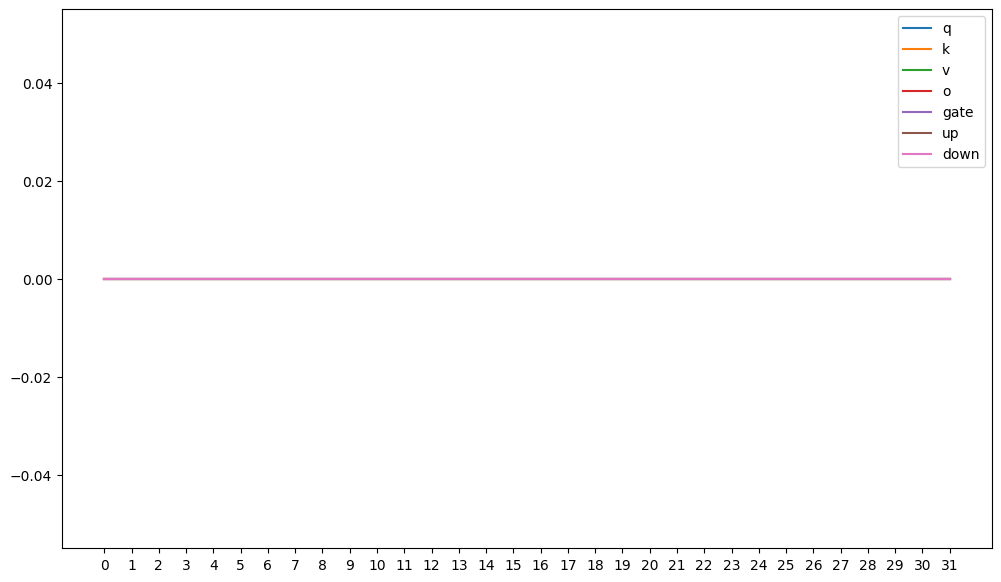

In [89]:
fig, ax = plt.subplots(figsize=(12,7))

# Loop through the dictionary and plot each line with a label
for key, values in deltas.items():
    ax.plot(values, label=key)
    ax.set_xticks(range(len(values)))
    
# Adding a legend to distinguish the lines
ax.legend();

In [83]:
torch.save(hf_saved_activations, "/home/ubuntu/models/debug/quant_hf_saved_activations")
torch.save(vllm_saved_activations, "/home/ubuntu/models/debug/quant_vllm_saved_activations")

### Loaded vs Saved Weights 

In [22]:
def create_quant_state(absmax, shape):
    quant_state = QuantState(absmax, dtype=torch.bfloat16)
    quant_state.shape = torch.Size(shape)
    quant_state.blocksize = 64
    quant_state.quant_type = "nf4"
    quant_state.code = quant_map
    return quant_state

In [65]:
# Sanity Check if weights are loaded correctly into vllm model.
pack_factor = 2
for n, p in model.named_parameters():

    print("Cheking:", n)
    
    if 'qkv_proj' in n:
        if 'absmax' in n: continue
        
        # Loaded qkv
        qkv_weight = model.get_parameter(n)
        qkv_absmax = model.get_parameter(n.replace(".weight", ".absmax"))
        qkv_shape = [qkv_weight.shape[0], qkv_weight.shape[1] * pack_factor]
        q_shape   = [qkv_weight.shape[0], qkv_weight.shape[1] * pack_factor // 3]
        
        absmax = qkv_absmax.contiguous().view(-1)
        quant_state = create_quant_state(absmax, qkv_shape)
        
        W_dq = bnb.functional.dequantize_4bit(qkv_weight.contiguous().view(-1,1), quant_state=quant_state)

        # Saved q proj
        q_proj_weight_name = n.replace("qkv_proj", "q_proj")
        q_proj_absmax_name = n.replace("qkv_proj", "q_proj").replace(".weight", ".absmax")
        
        absmax = quantized_state_dict[q_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, q_shape)
        
        W_q_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[q_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

        # Compare with HF model state dict
        param = Params4bit(hf_state_dict[q_proj_weight_name].t(), blocksize=64, compress_statistics=False, quant_type='nf4').cuda()
        W_q_proj_dq_hf = dequantize_4bit(param.data, param.quant_state)
        
        # Saved k proj
        k_proj_weight_name = n.replace("qkv_proj", "k_proj")
        k_proj_absmax_name = n.replace("qkv_proj", "k_proj").replace(".weight", ".absmax")
        
        absmax = quantized_state_dict[k_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, q_shape)
        
        W_k_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[k_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

        # Compare with HF model state dict
        param = Params4bit(hf_state_dict[k_proj_weight_name].t(), blocksize=64, compress_statistics=False, quant_type='nf4').cuda()
        W_k_proj_dq_hf = dequantize_4bit(param.data, param.quant_state)        

        # Saved v proj
        v_proj_weight_name = n.replace("qkv_proj", "v_proj")
        v_proj_absmax_name = n.replace("qkv_proj", "v_proj").replace(".weight", ".absmax")

        absmax = quantized_state_dict[v_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, q_shape)

        W_v_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[v_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

         # Compare with HF model state dict
        param = Params4bit(hf_state_dict[v_proj_weight_name].t(), blocksize=64, compress_statistics=False, quant_type='nf4').cuda()
        W_v_proj_dq_hf = dequantize_4bit(param.data, param.quant_state)       

        # Check whether loaded vs saved weights are equal after dequantization.
        assert torch.equal(W_dq, torch.cat([W_q_proj_dq, W_k_proj_dq, W_v_proj_dq], dim=1))

        assert torch.equal(W_dq, torch.cat([W_q_proj_dq_hf, W_k_proj_dq_hf, W_v_proj_dq_hf], dim=1))
    
    
    elif 'gate_up_proj' in n:
        if 'absmax' in n: continue
            
        # Loaded gate_up
        gate_up_weight = model.get_parameter(n)
        gate_up_absmax = model.get_parameter(n.replace(".weight", ".absmax"))
        gate_up_shape = [gate_up_weight.shape[0], gate_up_weight.shape[1] * pack_factor]
        gate_shape    = [gate_up_weight.shape[0], gate_up_weight.shape[1] * pack_factor // 2]

        absmax = gate_up_absmax.contiguous().view(-1)
        quant_state = create_quant_state(absmax, gate_up_shape)
        
        W_dq = bnb.functional.dequantize_4bit(gate_up_weight.contiguous().view(-1,1), quant_state=quant_state)

        # Saved gate_proj
        gate_proj_weight_name = n.replace("gate_up_proj", "gate_proj")
        gate_proj_absmax_name = n.replace("gate_up_proj", "gate_proj").replace(".weight", ".absmax")
        
        absmax = quantized_state_dict[gate_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, gate_shape)
        
        W_gate_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[gate_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

        # Saved up_proj
        up_proj_weight_name = n.replace("gate_up_proj", "up_proj")
        up_proj_absmax_name = n.replace("gate_up_proj", "up_proj").replace(".weight", ".absmax")
        
        absmax = quantized_state_dict[up_proj_absmax_name].cuda().contiguous().view(-1)
        quant_state = create_quant_state(absmax, gate_shape)

        W_up_proj_dq = bnb.functional.dequantize_4bit(quantized_state_dict[up_proj_weight_name].contiguous().view(-1,1).cuda(), quant_state=quant_state)

        # Check whether loaded vs saved weights are equal after dequantization.
        assert torch.equal(W_dq, torch.cat([W_gate_proj_dq, W_up_proj_dq], dim=1))
    
    
    else:
        # Check whether loaded vs saved weights are equal after dequantization.
        assert torch.equal(quantized_state_dict[n].data, p.data.cpu())
        
        # Loaded gate_up
        if any(l in n for l in ["o_proj", "down_proj"]):
            if "weight" in n:
                weight = model.get_parameter(n)
                absmax = model.get_parameter(n.replace(".weight", ".absmax"))
                shape = [weight.shape[0], weight.shape[1] * pack_factor]
                absmax = absmax.contiguous().view(-1)
                quant_state = create_quant_state(absmax, shape)
                W_dq = bnb.functional.dequantize_4bit(weight.contiguous().view(-1,1), quant_state=quant_state)

                # Compare with HF model state dict
                param = Params4bit(hf_state_dict[n].t(), blocksize=64, compress_statistics=False, quant_type='nf4').cuda()
                assert torch.equal(W_dq, dequantize_4bit(param.data, param.quant_state))
                
        else:
            # Compare with HF model state dict
            assert torch.equal(quantized_state_dict[n].data, hf_state_dict[n])

    
    if any(l in n for l in ["qkv_proj", "o_proj", "gate_up_proj", "down_proj"]) and "weight" in n:
        module = model.get_submodule(n.rpartition(".")[0])
        input_size = module.weight.shape[0]
        x = torch.randn(1,input_size).cuda().to(torch.bfloat16)
        out1 = module(x)
        if len(out1) > 1: out1 = out1[0]
        out2 = x @ W_dq
        
        # Check forward pass is correct.
        assert torch.equal(out1, out2)

    # print(p.view(-1)[:10])

Cheking: model.embed_tokens.weight
Cheking: model.layers.0.self_attn.qkv_proj.weight
Cheking: model.layers.0.self_attn.qkv_proj.absmax
Cheking: model.layers.0.self_attn.o_proj.weight
Cheking: model.layers.0.self_attn.o_proj.absmax
Cheking: model.layers.0.mlp.gate_up_proj.weight
Cheking: model.layers.0.mlp.gate_up_proj.absmax
Cheking: model.layers.0.mlp.down_proj.weight
Cheking: model.layers.0.mlp.down_proj.absmax
Cheking: model.layers.0.input_layernorm.weight
Cheking: model.layers.0.post_attention_layernorm.weight
Cheking: model.layers.1.self_attn.qkv_proj.weight
Cheking: model.layers.1.self_attn.qkv_proj.absmax
Cheking: model.layers.1.self_attn.o_proj.weight
Cheking: model.layers.1.self_attn.o_proj.absmax
Cheking: model.layers.1.mlp.gate_up_proj.weight
Cheking: model.layers.1.mlp.gate_up_proj.absmax
Cheking: model.layers.1.mlp.down_proj.weight
Cheking: model.layers.1.mlp.down_proj.absmax
Cheking: model.layers.1.input_layernorm.weight
Cheking: model.layers.1.post_attention_layernorm.we

In [66]:
# TODO: Check activations VLLM bnb vs HF bnb